In [165]:
import nba_api 
from nba_api.stats.static import teams
from nba_api.stats.static import players
from nba_api.stats.endpoints import FranchisePlayers as fp
from nba_api.stats.endpoints import CommonPlayerInfo as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.spatial import distance
from sklearn import preprocessing as pre
import numpy as np 


<h2> Retrieving Data </h2>

In [166]:
#storing all teams and players into lists
teams_list = teams.get_teams()
players_list = players.get_players()


#storing raptors teamid 
raptors_id = '1610612761'



In [167]:
#This extracts all players that ever played for the raptors 
tor_players = fp(league_id='00', per_mode_detailed='PerGame', season_type_all_star='Regular Season', team_id=raptors_id)

#stroing all raptors players in a dataframe 
tor_players_df = tor_players.get_data_frames()[0]




In [168]:
# this is just code to work mess around with data frames and understand them better 

# tor_players_df.iloc[20:25]
# tor_players_df.loc[tor_players_df['GP']>200]
# tor_players_df['PLAYER']
# tor_players_df = tor_players_df.sort_values(by=['GP'],ascending=False)
#tor_players_df.columns

<h2> Adding helper methods </h2>
<p> The stats that we want from players to include are pts, reb, ast, stl, blk, tov, pf which are already in this data frame. But to make the most accurate comparisons we are going to want TS% 3PAr and FTr which are not in the df therefore have to be calculated. These helper methods make such calculations </p>

In [169]:
#Helper methods that take in the original data frame and output each stat 
def add_true_shooting(df):
    list_of_TS = []
    #goes through each row of the df and uses data to calculate each stat
    for index, player in df.iterrows():
        #this if statement prevents a divide by zero exception
        if(player['FGA']==0):
            list_of_TS.append(0.00000)
            continue
        ts = player['PTS']/(2*(player['FGA']+(0.44*player['FTA'])))
        #appends this calculated stat to the list 
        list_of_TS.append(ts)
    #adds list to dataframe with proper header    
    df['TS'] = list_of_TS
    return df

#these are methods are similar to the one above just implementing their own stat
def add_3PAr(df):
    list_of_3PAr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_3PAr.append(0.00000)
            continue
        val = player['FG3A']/player['FGA']
        list_of_3PAr.append(val)
       
    df['3PAr'] = list_of_3PAr
    return df

def add_FTr(df):
    list_of_FTr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_FTr.append(0.00000)
            continue
        val = player['FTA']/player['FGA']
        list_of_FTr.append(val)
       
    df['FTr'] = list_of_FTr
    return df

In [170]:
#adding true shooting 3PAr and FTr to our data frame 
tor_players_df = add_true_shooting(add_3PAr(add_FTr(tor_players_df )))

#tor_players_df.head(30)

<h2> Extracting Players we want </h2>

85.38135593220339


[]

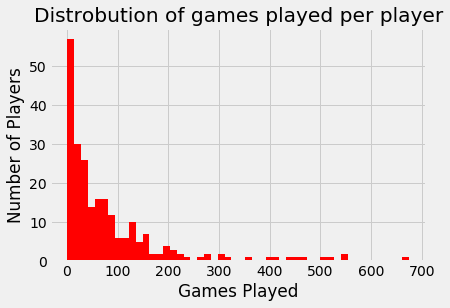

In [171]:
#checking what is the average number of games played 
print(tor_players_df['GP'].mean())

#tor_players_df.hist(column='GP').show()
plt.style.use('fivethirtyeight')

gamesPlayedHist, g = plt.subplots()

g.hist(tor_players_df['GP'],color='red',bins=50)
g.set_xlabel("Games Played")
g.set_ylabel("Number of Players")
g.set_title("Distrobution of games played per player")
g.plot()

In [172]:
#Only stroing players that have played over 50 games for the raptors
tor_players_df = tor_players_df.sort_values(by=['GP'],ascending=False)
#tor_players_df =  tor_players_df.loc[tor_players_df['GP']>50]

names = tor_players_df['PLAYER']
#tor_players_df 
tor_players_df .loc[(tor_players_df ['PLAYER'] == 'Malcolm Miller')]
# tor_players_df

,LEAGUE_ID,TEAM_ID,TEAM,PERSON_ID,PLAYER,SEASON_TYPE,ACTIVE_WITH_TEAM,GP,FGM,FGA,...,REB,AST,PF,STL,TOV,BLK,PTS,FTr,3PAr,TS
219,00,1610612761,Toronto Raptors,1626259,Malcolm Miller,Regular Season,1,50,0.64,1.56,...,0.68,0.24,0.54,0.12,0.18,0.1,1.92,0.179487,0.782051,0.570342


In [173]:
#here we are going to take the stats that are important for our comparisons
#tor_players_df = tor_players_df[['PLAYER','PTS', 'AST', 'REB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF'] ]

df_tor_numbers = tor_players_df[['PTS', 'AST', 'REB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF']]
avg_player = df_tor_numbers.mean()


avg_player

PTS     6.175421
AST     1.385410
REB     2.953078
STL     0.535183
BLK     0.353789
TS      0.492893
3PAr    0.226035
FTr     0.283929
TOV     0.976140
PF      1.697182
dtype: float64

In [174]:
#     x = df_tor_numbers.values #returns a numpy array
#     min_max_scaler = pre.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(x)
#     d = pd.DataFrame(x_scaled)

#features = ['PTS', 'AST', 'REB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF']


<h2> Finding the most average raptors player </h2> 
<p> Here we are going do use euclidian distance to find which player most closely ressembles these stats </p> 

In [175]:
#Firsr we have to append the mean average player to a dataframe
avg_player_df = pd.DataFrame([avg_player])
df_to_normalize = pd.concat([df_tor_numbers,avg_player_df])


In [176]:
#now we have to normalize the data 
x = df_to_normalize.values #returns a numpy array
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized_data = pd.DataFrame(x_scaled)

df_normalized_data.iloc[115]

0    0.072180
1    0.026024
2    0.072471
3    0.055663
4    0.035000
5    0.380228
6    0.782051
7    0.089744
8    0.050420
9    0.135000
Name: 115, dtype: float64

In [177]:
#here we are splitting the normalized data back into 2 dataframes 
# df_players = df_normalized_data.iloc[:115]
# df_avg = df_normalized_data.iloc[115]

df_normalized_data

,0,1,2,3,4,5,6,7,8,9
0,0.740518,0.333815,0.432456,0.450111,0.095926,0.357020,0.107102,0.203048,0.549020,0.555185
1,0.660737,0.771282,0.517537,0.689446,0.112841,0.382673,0.503157,0.174513,0.735230,0.730419
2,0.450712,0.193060,0.405848,0.472414,0.078782,0.353164,0.387990,0.116685,0.327142,0.619926
3,0.374866,0.778657,0.266944,0.414377,0.030000,0.381434,0.279059,0.099358,0.483393,0.431905
4,0.758896,0.237532,1.000000,0.361789,0.412573,0.380408,0.022870,0.256398,0.619658,0.652750
...,...,...,...,...,...,...,...,...,...,...
232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
233,0.000000,0.000000,0.106575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
234,0.225564,0.000000,0.852596,0.463855,0.700000,0.250000,0.000000,0.000000,0.000000,1.000000
235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280112,0.000000


In [178]:

#distance.cdist(df_normalized_data.iloc[115], df_normalized_data.iloc[1], 'euclidean')

mans = distance.euclidean(df_normalized_data.iloc[115],df_normalized_data.iloc[0])
mans2 = 1 - distance.cosine(df_normalized_data.iloc[115],df_normalized_data.iloc[1])
list(names).index('Kyle Lowry')
mans

1.3131606955329032

In [179]:
cos_dist = []
e_dist = []
for name in names:
    i = list(names).index(name)
    
    e_dist.append([name, distance.euclidean(df_normalized_data.iloc[-1],df_normalized_data.iloc[i])])
    cos_dist.append([name,1 - distance.cosine(df_normalized_data.iloc[-1],df_normalized_data.iloc[i])])
    
e_most_simlar = sorted(e_dist, key=lambda x: x[1])
cos_most_simlar = sorted(cos_dist, key=lambda x: x[1])

e_most_simlar

/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[['Lamond Murray', 0.14751313480395614],
 ['Sonny Weems', 0.19861085115940538],
 ['Jeremy Lin', 0.20855694128757382],
 ['Gary Forbes', 0.21152106019291175],
 ['Eric Williams', 0.21215878241558891],
 ['Juan Dixon', 0.21357069300177764],
 ['Jimmy King', 0.23071130376722604],
 ['Dion Glover', 0.2325034977271296],
 ['Antoine Wright', 0.24386055955481048],
 ['Joey Graham', 0.2467364819711421],
 ['Norman Powell', 0.24922673650023042],
 ['Tracy Murray', 0.2505959350673516],
 ['Jason Kapono', 0.2513321170829635],
 ['John Salmons', 0.2568621767580293],
 ['David Andersen', 0.256943552902536],
 ['Fred Jones', 0.2684741844833677],
 ['Shawn Respert', 0.27917878702209115],
 ['Cory Joseph', 0.281037161663312],
 ['Roger Mason Jr.', 0.2828057919613646],
 ['Jason Thompson', 0.28402768688824864],
 ['Delon Wright', 0.28413235585978636],
 ['Quincy Acy', 0.28743680006146866],
 ['Luis Scola', 0.28902830151634135],
 ['Greg Monroe', 0.29060739348933323],
 ['Alexis Ajinca', 0.2929708335503285],
 ['Art Long', 0.